#

# Compute area

### path and inputs

In [4]:
cd "C:\\Code\\ditto_v2"

C:\Code\ditto_v2


In [5]:
%pwd

'C:\\Code\\ditto_v2'

In [6]:
# Define the center point and radius
lat, lon = 50.0, 10.0  # Example coordinates
radius_km = 30
radius = radius_km * 1000  # Convert km to meters

### 

<>:5: SyntaxWarning: invalid escape sequence '\D'
<>:5: SyntaxWarning: invalid escape sequence '\D'
C:\Users\User\AppData\Local\Temp\ipykernel_6080\2671012487.py:5: SyntaxWarning: invalid escape sequence '\D'
  gdf_de = gpd.read_file('JupNB\DE_Data\VG250_GEM_WGS84.shp')


shape=(1, 30)


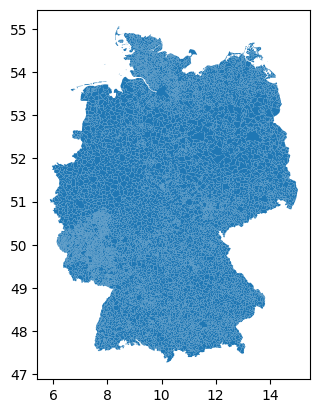

In [7]:
from shapely.geometry import Point
import geopandas as gpd

## GeoDataFrame with Germany's state boundaries
gdf_de = gpd.read_file('JupNB\DE_Data\VG250_GEM_WGS84.shp')


# Create a point object
point = Point(lon, lat)

result = gdf_de.geometry.contains(point)
gdf_point = gdf_de[result]

if gdf_point.empty:
    print('No data found')
else:
    print(f'shape={gdf_point.shape}')
    
# Plots
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# gdf_circle.plot(ax=ax, color='red', alpha=0.5)
gdf_de.plot(ax=ax)
plt.show()

In [8]:
import folium

def get_fg(point1, radius, epsg, color='blue') -> folium.FeatureGroup:
    gdf_point = gpd.GeoDataFrame(geometry=[point1], crs=f'EPSG:4326')

    gdf_point_epsg = gdf_point.to_crs(epsg=epsg) 
    gdf_circle = gdf_point_epsg.buffer(radius)
    gdf_circle = gpd.GeoDataFrame(geometry=gdf_circle)
    gdf_circle = gpd.GeoDataFrame(geometry=gdf_point.buffer(radius))

    fg_circle = folium.FeatureGroup(name=f'EPSG {epsg} [r={radius} m \
                                    color = "red" \
                                    area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2]')
    gjson_circle = folium.GeoJson(gdf_circle, color=color)
    gjson_circle.add_to(fg_circle)    
    return fg_circle



In [9]:
# import pandas as pd
# pd.set_option('display.max_columns', None)

# gdf_circle.head(2)

In [10]:
from functools import partial
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
from pyproj import Transformer

def transform_wgs84_aeqd(lon, lat) :
    point_transformed =Transformer.from_crs(4326, 3857, always_xy=True).transform(float(lat),float(lon))
    return point_transformed

def transform_aeqd_wgs84(y,x) :
    point_transformed = Transformer.from_crs(3857, 4326, always_xy=True).transform(y,x)
    return point_transformed

# create a circle with a specified radius in meters around a point defined using latitude and longitude
def circle_around_lat_lon_point(lon, lat, radius) : 
    # lon, lat = 0, 42  # Example coordinates for San Francisco
    # radius = 30000  # Radius in meters

    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lon)
    wgs84_to_aeqd = partial(pyproj.transform, pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"), pyproj.Proj(local_azimuthal_projection))
    aeqd_to_wgs84 = partial(pyproj.transform, pyproj.Proj(local_azimuthal_projection), pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"))

    center = Point(float(lon), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    # print(f'x{point_transformed.x}, y={point_transformed.y}')
    buffer = point_transformed.buffer(radius)
    circle_poly = transform(aeqd_to_wgs84, buffer)
    return circle_poly

In [11]:
from geopy.distance import geodesic


def compute_dist_to_lat_lon(gdf,lon,lat,col_out:str='dist',units:str='km',round_dec:int=2):
    point_of_interest = (lat,lon)
    if units == 'km':
        gdf[col_out] = gdf.geometry.apply(
            lambda row: geodesic(point_of_interest, (row.y, row.x)).kilometers)
    elif units == 'm':
        gdf[col_out] = gdf.geometry.apply(
            lambda row: geodesic(point_of_interest, (row.y, row.x)).meters)
    elif units == 'mi':
        gdf[col_out] = gdf.geometry.apply(
            lambda row: geodesic(point_of_interest, (row.y, row.x)).miles)
    else:
        raise ValueError("units must be one of the following [km,m,mi]")
    gdf[col_out] = round(gdf[col_out], round_dec)
    return gdf

In [ ]:
# lon_point = 0.0
# lat_point = 42.0
# p = transform_wgs84_aeqd(lon=lon_point, lat=lat_point)
# q = transform_aeqd_wgs84(p[0],p[1])
# r = circle_around_lat_lon_point(42,0,10000)
# print(f'lat={lat_point}, lon={lon_point}')
# print(f'p={p}')
# print(f'q={q}')

# print(f'r={r}')

In [13]:
from pyproj import Transformer, CRS

lat = 42
lon = 0
print(f'{lat}, {lon}')

transformer = Transformer.from_crs(4326, 3857, always_xy=True)#, always_xy=True)
point_3857 =transformer.transform(lat,lon)
print(point_3857)

transformer2 = Transformer.from_crs(3857, 4326, always_xy=True)
point_wgs84 = transformer2.transform(point_3857[0], point_3857[1])
print(point_wgs84)


gdf_p = gpd.GeoDataFrame(geometry=[Point(lat,lon)], crs=f'EPSG:4326')
print(gdf_p)
gdf_q = gdf_p.to_crs(3857)
print(gdf_q)
gdf_r = gdf_q.to_crs(4326)
print(gdf_r)

42, 0
(4675418.613317491, 0.0)
(42.0, 0.0)
       geometry
0  POINT (42 0)
                geometry
0  POINT (4675418.613 0)
       geometry
0  POINT (42 0)


In [27]:
gdf_bl = gdf_de[gdf_de['SN_L'] == '08'] # Baden-Württemberg
gdf_de = gdf_bl
gdf_de# gdf_bw = gdf_bw['']

,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,...,NUTS,ARS_0,AGS_0,WSK,EWZ,KFL,DLM_ID,EPK,EPK_norm,geometry
5198,DEBKGVG20000040K,2022-12-20,6,4,1,081110000000,08111000,081110000000,Stuttgart,Stadt,...,DE111,081110000000,08111000,1973-01-01,632865,207,DEBKGDL20000DZKQ,3057.318841,0.0,"POLYGON ((9.22518 48.86601, 9.225 48.86485, 9...."
5199,DEBKGVG20000040L,2022-12-20,6,4,1,081150003003,08115003,081150003003,Böblingen,Stadt,...,DE112,081150003003,08115003,2009-01-01,51460,39,DEBKGDL20000DZZJ,1319.487179,0.0,"POLYGON ((9.05061 48.70344, 9.05447 48.70231, ..."
5200,DEBKGVG20000040M,2022-12-20,6,4,1,081150028028,08115028,081150028028,Leonberg,Stadt,...,DE112,081150028028,08115028,2009-01-01,49512,48,DEBKGDL20000E4K3,1031.500000,0.0,"POLYGON ((8.99417 48.83296, 8.99545 48.83238, ..."
5201,DEBKGVG20000040N,2022-12-20,6,4,1,081150029029,08115029,081150029029,Magstadt,Gemeinde,...,DE112,081150029029,08115029,2009-01-01,9789,19,DEBKGDL20000E25V,515.210526,0.0,"POLYGON ((8.96454 48.76285, 8.96572 48.76283, ..."
5202,DEBKGVG20000040O,2022-12-20,6,4,1,081150041041,08115041,081150041041,Renningen,Stadt,...,DE112,081150041041,08115041,2009-01-01,18596,31,DEBKGDL20000E25W,599.870968,0.0,"POLYGON ((8.92022 48.79948, 8.92302 48.79847, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6296,DEBKGVG2000004V1,2022-12-20,6,4,1,084375006065,08437065,084375006065,Krauchenwies,Gemeinde,...,DE149,084375006065,08437065,2009-01-01,5087,44,DEBKGDL20000DWWG,115.613636,0.0,"POLYGON ((9.23496 48.03216, 9.24058 48.03086, ..."
6297,DEBKGVG2000004V2,2022-12-20,6,4,1,084375006104,08437104,084375006104,Sigmaringen,Stadt,...,DE149,084375006104,08437104,2009-01-01,18375,92,DEBKGDL20000DWYP,199.728261,0.0,"POLYGON ((9.17297 48.1542, 9.17497 48.15074, 9..."
6298,DEBKGVG2000004V3,2022-12-20,6,4,1,084375006105,08437105,084375006105,Sigmaringendorf,Gemeinde,...,DE149,084375006105,08437105,2009-01-01,3735,12,DEBKGDL20000E1A1,311.250000,0.0,"MULTIPOLYGON (((9.26146 48.03686, 9.26221 48.0..."
6299,DEBKGVG2000004V4,2022-12-20,6,4,1,084375007102,08437102,084375007102,Schwenningen,Gemeinde,...,DE149,084375007102,08437102,2009-01-01,1681,19,DEBKGDL20000DWNN,88.473684,0.0,"POLYGON ((9.0153 48.12451, 9.01716 48.121, 9.0..."


In [33]:
l_epsg = [
    # 6933, 
        #   3857,    ## metric coordinate system 
        #   3310,
          4326,
]
l_color = ['green', 
           'red',
           'black'
           ]
l_cols_non_serializable = [
    # 'centroid',  # Geometry Points
    'WSK','BEGINN', # Datetimes
]


lat = 48
lon = 9
radius = 30000

dict_gdf_de = {}

for epsg in l_epsg:
    gdf_epsg = gdf_de.to_crs(epsg=4326)
    
    if epsg == 4326:
        epsg_proj = 6933
    else:
        epsg_proj = epsg

    gdf_projected = gdf_epsg.to_crs(epsg=6933)
    gdf_epsg['KFL_GPD'] = round(gdf_projected.geometry.area / 10**6, 2)

    gdf_epsg = gdf_epsg.to_crs(epsg=4326)
    
    # gdf_epsg['centroid'] = gdf_epsg.geometry.centroid
    gdf_epsg['lat'] = gdf_epsg.geometry.centroid.y
    gdf_epsg['lon'] = gdf_epsg.geometry.centroid.x


    gdf_epsg = gdf_epsg.to_crs(epsg=epsg_proj)
    dict_gdf_de[epsg] = gdf_epsg

# # Compute the centroid of each geometry
# gdf_de['centroid'] = gdf_de['geometry'].centroid
# # Extract latitude and longitude from the Point geometries
# gdf_de['lon'] = gdf_de['geometry'].centroid.x
# gdf_de['lat'] = gdf_de['geometry'].centroid.y
# # dict_gdf_de[3857] = gdf_de.to_crs(epsg=3857)

C:\Users\User\AppData\Local\Temp\ipykernel_6080\1143066767.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_epsg['lat'] = gdf_epsg.geometry.centroid.y
C:\Users\User\AppData\Local\Temp\ipykernel_6080\1143066767.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_epsg['lon'] = gdf_epsg.geometry.centroid.x


In [143]:
import pandas as pd
import folium.features
from pyproj import CRS
from shapely import geometry
import folium
from src.functionality_maps import f_maps

dict_epsg = {}


center_point = geometry.Point(lon, lat)
gdf_point = gpd.GeoDataFrame(geometry=[center_point], crs=f'EPSG:4326')
fg_point = folium.FeatureGroup(name=f'Center point [lat={lat}, lon={lon}]')
gjson_point = folium.Marker([center_point.y, center_point.x], 
                            icon=folium.Icon(color="red"),
                            tooltip=folium.features.GeoJsonTooltip(fields=['geometry'], values=['coordinates'])
                            )

gjson_point.add_to(fg_point)

gdf = gpd.GeoDataFrame(geometry=[center_point], crs=CRS.from_epsg(4326))
# circle_30k_4326 = gdf.buffer(radius_m)
for epsg,color in zip(l_epsg,l_color):
    dict_epsg[epsg] = {}

    if epsg != 4326:
        gdf_point_epsg = gdf_point.to_crs(epsg=epsg)
        gdf_circle = gdf_point_epsg.buffer(radius)
    
        gdf_circle = gpd.GeoDataFrame(geometry=gdf_circle)

    else:
        ############# CIRCLE PROJECTION IN 4326 ####################
        # Convert the Shapely circle to a geoDataFrame
        poly_circle = circle_around_lat_lon_point(lon, lat, radius=radius)
        gdf = gpd.GeoSeries([poly_circle])
        gdf_circle = gdf.to_frame(name='geometry').set_crs(epsg=epsg)
        gdf_circle['area'] = round(gdf_circle.to_crs(epsg=3857).geometry.area.sum() / 10**6, 2)


    dict_epsg[epsg]['gdf']= gdf_circle

    fg_circle = folium.FeatureGroup(name=f'EPSG {epsg} [r={radius_km} Km \
                                    color = {color} \
                                    area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2]')
    
    gjson_circle = folium.GeoJson(gdf_circle, color=color)
    gjson_circle.add_to(fg_circle)

    dict_epsg[epsg]['fg'] = fg_circle

        # # Generate FeatureGroup and add geojson
        # fg_circle = folium.FeatureGroup(name=f'EPSG={epsg} [r={radius_km} Km \
        #                                 color = "black", \
        #                                 area = {gdf['area'].sum()} Km2]')
        # folium.GeoJson(gdf, color='black').add_to(fg_circle)

        # dict_epsg[epsg]= {'gdf' : gdf, 'fg' : fg_circle}

############ CONTAINS POINT ############
dict_op = {}
result = gdf_de.geometry.contains(center_point)     
# Find the geometry that contains a point
gdf_de_point = gdf_de[result]                       
# # Create a GeoDataFrame with the point
gdf_de_point = gdf_de_point.drop(l_cols_non_serializable, axis=1) 
# Remove timestamp columns (not serializable)

fgc = f_maps.get_folium_featuregroup(gdf_de_point, fg_name=f'Container point [{center_point}]',
                                    fields=['GEN', 'EWZ', 'KFL', 'AGS'],
                                    aliases = ['Name', 'Population', 'Area', 'AGS'])

dict_op['contains'] = {'fg' : fgc}

# ############ GEOMETRY INTERSECTION ############
# Find the intersection
print('Finding the intersections')
dict_int = {}
for epsg in l_epsg:

    print(f'epsg={epsg}')
    gdf_de_int = gpd.sjoin(dict_gdf_de[epsg].to_crs(epsg=epsg), dict_epsg[epsg]['gdf'].to_crs(epsg=epsg), 
                        how="inner", predicate="intersects") \
                            .drop(l_cols_non_serializable, axis=1) 
    print(f' shape={gdf_de_int.shape[0]}')
    # Calculate the distance between each point in gdf and the other point
    # distances = gdf_de_int.geometry.distance(center_point)
    # print(gdf_de_int)
    # gdf_de_int = gdf_de_int.to_crs(epsg=3310, inplace=True)
    # distances = gdf_de_int.geometry.apply(lambda g: center_point.distance(g))
    
#     # # Add the distances as a new column in the GeoDataFrame\n    
#     # gdf_de_int['stance_km'''round(distances / 10**6,3)\n    
#     # # gdf_de_int = gdf_de_int.to_crs(epsg=epsg)\n\n    
    fgi = f_maps.get_folium_featuregroup(gdf_de_int, 
                                        fg_name=f'Intersection EPSG={epsg} [#={gdf_de_int.shape[0]}]',
                                        #  A={round(gdf_de_int.geometry.area.sum() / 10**6,2)} Km2, \                           
                                        #  A_data={gdf_de_int.KFL.sum()} Km2]',
                                        fields=['GEN', 'EWZ', 'KFL', 'KFL_GPD', 'AGS'
                                                #  'lat', 'lon'
                                                # 'distance_km'      
                                                ],
                                        aliases = ['Name', 'Population', 'Area', 'Area_GPD','AGS',
                                                            # 'lat', 'lon''   '  '   ''   '  '   '                  
                                                            #    'Distance [Km]''            ' '             '                 
                                                    ])   
    dict_int[epsg] = {'fg' : fgi, 'gdf':gdf_de_int}

# ##'###### GEOMETRY UNION ############
# Find the union
dict_uni = {}
dict_cir_merged = {}
dict_gem_inside = {}
dict_gem_partly = {}
dict_gem_outside = {}
for epsg in l_epsg:
    # if epsg == 4326:
    epsg_proj = 6933
    # else:
    #     epsg_proj = epsg

    print('Finding the unions...')
    gdf_total = dict_gdf_de[epsg].to_crs(epsg=epsg_proj)
    gdf_circle_epsg = dict_epsg[epsg]['gdf'].to_crs(epsg=epsg_proj)
    gdf_circle = gpd.overlay(gdf_total, gdf_circle_epsg, \
                             how='intersection').drop(l_cols_non_serializable,axis=1)
    
    print(f'  EPSG={epsg}, shape [{gdf_circle.shape[0]}]')

    gdf_circle['KFL_int'] = round(gdf_circle.geometry.area / 10**6, 2)
    gdf_circle['PERC_int'] = round(gdf_circle['KFL_int'] / gdf_circle['KFL_GPD'], 4)
                                                
    gdf_circle['EWZ_int'] = gdf_circle['EWZ'] * gdf_circle['PERC_int']
    gdf_circle['EWZ_int'] = gdf_circle['EWZ_int'].astype(int)
    gdf_circle['EWZ_out'] = gdf_circle['EWZ'] - gdf_circle['EWZ_int']
    gdf_circle['EWZ_out'] = gdf_circle['EWZ_out'].astype(int)
    
    gdf_circle['EWZ_sum'] = gdf_circle['EWZ_int'] + gdf_circle['EWZ_out']
    gdf_circle['EWZ_ref'] = gdf_circle['EWZ']
    gdf_circle['EWZ_per'] = round(gdf_circle['EWZ_int']/gdf_circle['EWZ_sum'],4)

    
    gdf_circle['KFL_int'] = gdf_circle['KFL_int']#.sum()
    gdf_circle['KFL_sum'] = gdf_circle['KFL_GPD']#.sum()
    gdf_circle['KFL_out'] = gdf_circle['KFL_GPD'] - gdf_circle['KFL_int'] 
    gdf_circle['KFL_ref'] = gdf_circle['KFL']#.sum()
    gdf_circle['KFL_per'] = round(gdf_circle['KFL_int'] / gdf_circle['KFL_sum'], 4)
                                                                                                                                                                                                                                                                                                                                                                                                                                         
    fg_union = f_maps.get_folium_featuregroup(gdf_circle, 
                                               fg_name=f'Circle EPSG={epsg} [r={radius_km} Km, \
                                                        color = {color}, \
                                                        area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2',
                                                fields=['EWZ_int', 'EWZ_out', 
                                                        'EWZ_sum', 'EWZ_ref', 'EWZ_per', 
                                                        'KFL_int', 'KFL_out', 'KFL_sum', 'KFL_ref', 'KFL_per' 
                                                        ],
                                                aliases = ['Pop_int', 'Pop_out',
                                                           'Pop_sum', 'Pop_ref', 'Pop [%]',
                                                           'Area_int', 'Area_out', 'Area_sum','Area_ref', 'Area [%]'
                                                        ])
    dict_uni[epsg] = {'fg' : fg_union, 'gdf' : gdf_circle}

    ################### Distance to point of interest ###################
    gdf = pd.DataFrame(gdf_circle[['ARS','lat','lon','KFL_per']])
    gdf = gpd.GeoDataFrame(gdf, crs='epsg:4326', geometry=[Point(xy) for xy in zip(gdf['lon'], gdf['lat'])])
    gdf = compute_dist_to_lat_lon(gdf,lat=center_point.y, lon=center_point.x, round_dec=2)

    #######################  Gemeinde Markers  ##########################
    print('Finding the Gemeinden...')
    
    gdf_inside = gdf[gdf['KFL_per'] == 1.0]
    print(f' gdf_inside={gdf_inside.shape[0]}')
    gdf_partly = gdf[gdf['KFL_per'] != 1.0]
    print(f'  gdf_partly={gdf_partly.shape[0]}')
    
    gdf_outside = gdf_total.merge(gdf_circle, on=['AGS'], how='left', indicator=True)
    gdf_outside = gdf_outside[gdf_outside['_merge'] == 'left_only']
    print(f'  gdf_outside={gdf_outside.shape[0]}')
    
    gdf_outside = gdf_total[['OBJID','AGS','lat','lon']].merge(gdf_circle[['OBJID']], on='OBJID', how='left', indicator=True)
    gdf_outside = gdf_outside[gdf_outside['_merge'] == 'left_only'].drop('_merge',axis=1)

    gdf_outside = gpd.GeoDataFrame(gdf_outside, crs='epsg:4326', geometry=[Point(xy) for xy in zip(gdf_outside['lon'], gdf_outside['lat'])])
    gdf_outside = compute_dist_to_lat_lon(gdf_outside,lat=center_point.y, lon=center_point.x, round_dec=2)
    

    fg_inside = folium.FeatureGroup(name=f'Inside EPSG={epsg} [{gdf_inside.shape[0]}]')
    for index, row in gdf_inside.iterrows():
        tooltip = folium.Tooltip(f"Distance[Km]: {row['dist']}")
        popup = folium.Popup(f"lat: {row['lat']}\nLon: {row['lon']}")
        folium.Marker(location=[row.lat, row.lon],
                      popup=popup,
                      icon=folium.Icon(color="darkgreen"),
                      tooltip=tooltip
                     ).add_to(fg_inside)
        
    fg_partly = folium.FeatureGroup(name=f'Partly EPSG={epsg} [{gdf_partly.shape[0]}]')
    for index, row in gdf_partly.iterrows():
        tooltip = folium.Tooltip(f"Distance[Km]: {row['dist']}")
        popup = folium.Popup(f"lat: {row['lat']}\nLon: {row['lon']}")
        folium.Marker(location=[row.lat, row.lon],
                      popup=popup,
                      icon=folium.Icon(color="orange"),
                      tooltip=tooltip
                     ).add_to(fg_partly)
    
    fg_outside = folium.FeatureGroup(name=f'Outside EPSG={epsg} [{gdf_outside.shape[0]}]')
    for index, row in gdf_outside.iterrows():
        tooltip = folium.Tooltip(f"Distance[Km]: {row['dist']}")
        popup = folium.Popup(f"lat: {row['lat']}\nLon: {row['lon']}")
        folium.Marker(location=[row.lat, row.lon],
                      popup=popup,
                      icon=folium.Icon(color="red"),
                      tooltip=tooltip
                     ).add_to(fg_outside)
        
        
    dict_gem_inside[epsg] = {'gdf' : gdf_inside, 'fg' : fg_inside}
    dict_gem_partly[epsg] = {'gdf' : gdf_partly, 'fg' : fg_partly}
    dict_gem_outside[epsg] = {'gdf' : gdf_outside, 'fg' : fg_outside}

    ############# Merged_polygon ##############
    print('Merging the unions...')
    poly_merged = gdf_circle.geometry.union_all()
    gdf = gpd.GeoSeries([poly_merged])
    gdf_merged = gdf.to_frame(name='geometry').set_crs(epsg=6933)

    gdf_merged['EWZ_int'] = gdf_circle['EWZ_int'].sum()
    gdf_merged['EWZ_int'] = gdf_circle['EWZ_int'].sum()
    gdf_merged['EWZ_out'] = gdf_circle['EWZ_out'].sum()
    gdf_merged['EWZ_sum'] = gdf_circle['EWZ_sum'].sum()
    gdf_merged['EWZ_ref'] = gdf_circle['EWZ_ref'].sum()
    gdf_merged['EWZ_per'] = gdf_circle['EWZ_per']


    gdf_merged['KFL_int'] = gdf_circle['KFL_int'].sum()
    gdf_merged['KFL_out'] = gdf_circle['KFL_out'].sum()
    gdf_merged['KFL_sum'] = gdf_circle['KFL_sum'].sum()
    gdf_merged['KFL_ref'] = gdf_circle['KFL_ref'].sum()
    gdf_merged['KFL_per'] = gdf_circle['KFL_per']

    gdf_merged['num_loc'] = gdf_circle.shape[0]
    gdf_merged['num_in'] = gdf_inside.shape[0]
    gdf_merged['num_part'] = gdf_partly.shape[0]

    fg_circle_merged = f_maps.get_folium_featuregroup(gdf_merged,
                                                        fg_name = f'Merged Circle EPSG={epsg}, [r={radius_km} Km, \
                                                            color = {color}',
                                                        fields=[
                                                            'num_loc', 
                                                            'num_in', 
                                                            'num_part',
                                                            'EWZ_int', 
                                                                # 'EWZ_out', 'EWZ_sum', 'EWZ_ref', 'EWZ_per', 
                                                                'KFL_int', 
                                                                # 'KFL_out', 'KFL_sum', 'KFL_ref', 'KFL_per' 
                                                            ],
                                                        aliases = [
                                                            '# Localities total', 
                                                            '# Localities inside',
                                                            '# Localities partially inside',
                                                            'Population', 
                                                                    #  'Pop_out', 'Pop_sum', 'Pop_ref', 'Pop [%]',
                                                                    'Area [Km2]', 
                                                                    # 'Area_out', 'Area_sum','Area_ref', 'Area [%]'
                                                            ])

    dict_cir_merged[epsg] = {'gdf' : gdf_merged, 'fg' : fg_circle_merged}

#########'###  MAPS ##''#'###############
print('Generating map')

m = folium.Map()
m.add_child(fg_point)
l_dicts = [
    # dict_epsg, 
    # dict_op,
    dict_int,
    dict_uni,
    # dict_dif,
    # dict_circle,
    dict_cir_merged, 
    dict_gem_inside,
    dict_gem_partly,
    dict_gem_outside
]

for di in l_dicts:
    for k,v in di.items():
        # print(f'k={k}')
        m.add_child(v['fg'])

# fg_circle.add_to(m)

# fg_mark.add_to(m)\n
 
folium.LayerControl(position='topright',collapsed=False).add_to(m)
m.add_child(folium.LatLngPopup())

m.fit_bounds(m.get_bounds())
m

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\shapely\ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))
C:\Users\User\AppData\Local\Temp\ipykernel_6080\3671595540.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area = {round (gdf_circle.geometry.area.sum() / 10**6, 2)} Km2]')


Finding the intersections
epsg=4326
 shape=107
Finding the unions...
  EPSG=4326, shape [107]
Finding the Gemeinden...
 gdf_inside=71
  gdf_partly=36
  gdf_outside=996
Merging the unions...
Generating map


In [91]:
m.save('test_map.html')

In [99]:
gdf_circle[gdf_circle['AGS'] == '08325049']

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,PERC_int,EWZ_int,EWZ_out,EWZ_sum,EWZ_ref,EWZ_per,KFL_sum,KFL_out,KFL_ref,KFL_per
0,DEBKGVG2000004JM,6,4,1,083255003049,08325049,083255003049,Rottweil,Stadt,63,...,0.1917,4890,20623,25513,25513,0.1917,71.84,58.07,71,0.1917


In [96]:
gdf_outside = gdf_de[~gdf_de[['AGS']].isin(gdf_circle[['AGS']]).all(axis=1)]
print(gdf_total.shape)
print(gdf_circle.shape)
print(gdf_outside.shape)

(1103, 33)
(107, 43)
(1103, 30)


In [122]:
gdf_total.head()

,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,...,WSK,EWZ,KFL,DLM_ID,EPK,EPK_norm,geometry,KFL_GPD,lat,lon
5198,DEBKGVG20000040K,2022-12-20,6,4,1,081110000000,08111000,081110000000,Stuttgart,Stadt,...,1973-01-01,632865,207,DEBKGDL20000DZKQ,3057.318841,0.0,"POLYGON ((890102.993 5519238.077, 890086.186 5...",209.95,48.774577,9.172008
5199,DEBKGVG20000040L,2022-12-20,6,4,1,081150003003,08115003,081150003003,Böblingen,Stadt,...,2009-01-01,51460,39,DEBKGDL20000DZZJ,1319.487179,0.0,"POLYGON ((873259.861 5505468.821, 873632.552 5...",38.85,48.681833,9.019747
5200,DEBKGVG20000040M,2022-12-20,6,4,1,081150028028,08115028,081150028028,Leonberg,Stadt,...,2009-01-01,49512,48,DEBKGDL20000E4K3,1031.500000,0.0,"POLYGON ((867814.342 5516442.962, 867937.043 5...",48.93,48.790237,9.007012
5201,DEBKGVG20000040N,2022-12-20,6,4,1,081150029029,08115029,081150029029,Magstadt,Gemeinde,...,2009-01-01,9789,19,DEBKGDL20000E25V,515.210526,0.0,"POLYGON ((864954.659 5510505.775, 865068.904 5...",19.18,48.744856,8.979303
5202,DEBKGVG20000040O,2022-12-20,6,4,1,081150041041,08115041,081150041041,Renningen,Stadt,...,2009-01-01,18596,31,DEBKGDL20000E25W,599.870968,0.0,"POLYGON ((860679.27 5513608.844, 860949.389 55...",30.93,48.772206,8.924277


In [124]:
del gdf_merge

,OBJID,AGS,lat,lon
0,DEBKGVG20000040K,08111000,48.774577,9.172008
1,DEBKGVG20000040L,08115003,48.681833,9.019747
2,DEBKGVG20000040M,08115028,48.790237,9.007012
3,DEBKGVG20000040N,08115029,48.744856,8.979303
4,DEBKGVG20000040O,08115041,48.772206,8.924277
...,...,...,...,...
1073,DEBKGVG2000004UC,08436081,47.692660,9.806324
1074,DEBKGVG2000004UD,08436083,47.864911,9.424598
1075,DEBKGVG2000004UE,08436095,47.809417,9.482037
1076,DEBKGVG2000004UF,08436087,47.894607,9.622313


In [64]:
g2=gdf_circle[gdf_circle['AGS'] == '08335079']
g2

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,PERC_int,EWZ_int,EWZ_out,EWZ_sum,EWZ_ref,EWZ_per,KFL_sum,KFL_out,KFL_ref,KFL_per
56,DEBKGVG2000004M4,6,4,1,083355006079,08335079,083355006079,Stockach,Stadt,63,...,1.0,17490,0,17490,17490,1.0,69.37,0.0,69,1.0


In [66]:
g1=gdf_total[gdf_total['AGS'] == '08335079']
g1

,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,...,WSK,EWZ,KFL,DLM_ID,EPK,EPK_norm,geometry,KFL_GPD,lat,lon
5975,DEBKGVG2000004M4,2022-12-20,6,4,1,083355006079,08335079,083355006079,Stockach,Stadt,...,2017-08-16,17490,69,DEBKGDL20000DXPI,253.478261,0.0,"MULTIPOLYGON (((863134.692 5436487.61, 863197....",69.37,47.856131,9.0156


In [101]:
g1[['AGS']].isin(g2[['AGS']])

,AGS
5975,False


In [69]:
g3 = g1[~g1[['AGS']].isin(g2[['AGS']]).all(axis=1)]
g3

,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,...,WSK,EWZ,KFL,DLM_ID,EPK,EPK_norm,geometry,KFL_GPD,lat,lon
5975,DEBKGVG2000004M4,2022-12-20,6,4,1,083355006079,08335079,083355006079,Stockach,Stadt,...,2017-08-16,17490,69,DEBKGDL20000DXPI,253.478261,0.0,"MULTIPOLYGON (((863134.692 5436487.61, 863197....",69.37,47.856131,9.0156


In [41]:
gdf_circle.head(1)

,OBJID,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,IBZ,...,PERC_int,EWZ_int,EWZ_out,EWZ_sum,EWZ_ref,EWZ_per,KFL_sum,KFL_out,KFL_ref,KFL_per
0,DEBKGVG2000004JM,6,4,1,083255003049,08325049,083255003049,Rottweil,Stadt,63,...,0.1917,4890,20623,25513,25513,0.1917,71.84,58.07,71,0.1917


In [40]:
gdf_outside.head(1)

,OBJID,BEGINN,ADE,GF,BSG,ARS,AGS,SDV_ARS,GEN,BEZ,...,WSK,EWZ,KFL,DLM_ID,EPK,EPK_norm,geometry,KFL_GPD,lat,lon
5198,DEBKGVG20000040K,2022-12-20,6,4,1,081110000000,08111000,081110000000,Stuttgart,Stadt,...,1973-01-01,632865,207,DEBKGDL20000DZKQ,3057.318841,0.0,"POLYGON ((890102.993 5519238.077, 890086.186 5...",209.95,48.774577,9.172008


In [30]:
m = folium.Map()
m.add_child(folium.LatLngPopup())
m

In [ ]:
gdf_int = dict_int[4326]['gdf']
gdf_int.shape[0]

In [ ]:
gdf_de_only = gdf_de[~gdf_de[['ARS']].isin(gdf_int[['ARS']]).all(axis=1)]
gdf_de_only.shape[0]

In [ ]:
poly_merged = gdf_circle.geometry.union_all()
gdf = gpd.GeoSeries([poly_merged])
gdf_merged = gdf.to_frame(name='geometry').set_crs(epsg=6933)
gdf_merged.plot()

In [ ]:
gdf_merged.geometry.plot()

In [ ]:
dict_uni[4326]['gdf']

In [ ]:
epsg=4326
if epsg == 4326:
    epsg_proj = 3857
else:
    epsg_proj = epsg
gdf_de_uni = gpd.overlay(dict_gdf_de[epsg].to_crs(epsg=epsg_proj), dict_epsg[epsg]['gdf'].to_crs(epsg=epsg_proj), \
                            how='intersection').drop(l_cols_non_serializable,axis=1)

gdf_de_uni

In [ ]:
_ih[-5:]

In [ ]:
gdf_int = dict_int[4326]['gdf']
gdf_int.head(5)

In [ ]:
center_point.y, center_point.x

In [ ]:
gdf_int.geometry

In [ ]:
gdf_int = gdf_int.to_crs(epsg=3310)#, inplace=True)
distances = gdf_int.geometry.apply(lambda g: center_point.distance(g))

# Add the distances as a new column in the GeoDataFrame
gdf_int['distance_km'] = round(distances / 10**6,3)
gdf_int.head(5)

In [ ]:
# Convert the Shapely circle to a GeoSeries
gdf = gpd.GeoSeries([circle_poly])

# Convert the GeoSeries to a GeoDataFrame
gdf = gdf.to_frame(name='geometry')

In [ ]:

print(f'lat={lat}, lon={lon}')
circle = geometry.Point(lat, lon).buffer(radius)
circle#point_3857.geometry.values[0].exterior.coords.xy


center_point = geometry.Point(lon, lat)
gdf = gpd.GeoDataFrame(geometry=[center_point], crs=CRS.from_epsg(3857))
point_3857 = gdf.buffer(radius)



In [ ]:
.geo

In [ ]:

# transformer = Transformer.from_crs(4326, 3857, always_xy=True)
# point00 = Point(0,0)
# gdf_cir_3857 = point00.buffer(radius)
# print(f'point_3857={point_3857}')

# # List of points to transform
# points = [(22.95, 40.63), (22.81, 40.53), (23.51, 40.86)]
# transformed_points = [transformer.transform(*pt) for pt in points]

# transformer2 = Transformer.from_crs(3857, 4326, always_xy=True)
# center_point = Point(point_3857[0],point_3857[1])
# gdf_point = gpd.GeoDataFrame(geometry=[center_point], crs=3857)

# gdf.set_geometry(gdf_cir.geometry.apply(lambda row: transformer2.transform(row.geometry)))

lat = 51
lon = 10
radius = 10000

fg_point = folium.FeatureGroup(name=f'Center point [lat={lat}, lon={lon}]')
folium.Marker([lat, lon], icon=folium.Icon(color="red")).add_to(fg_point)


poly_circle = circle_around_lat_lon_point(lon, lat, radius)
# Convert the Shapely circle to a geoDataFrame
gdf = gpd.GeoSeries([poly_circle])
gdf = gdf.to_frame(name='geometry').set_crs(epsg=4326)
gdf['area'] = gdf.to_crs(epsg=3857).geometry.area.sum()
# Generate FeatureGroup and add geojson
fg_circle = folium.FeatureGroup(name=f'Circle, EPSG=4326 [r={radius_km} Km]')
folium.GeoJson(gdf, color='green').add_to(fg_circle)   

###############  MAP  ##########################
print('Generating map...')
m = folium.Map()
m.add_child(fg_point)
m.add_child(fg_circle)

# # fg_mark.add_to(m)
# folium.LatLngPopup().add_to(m)
m.add_child(folium.LatLngPopup())
m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

In [ ]:

newport_ri = (51,10)
cleveland_oh = (51, 10.4288)
print(geodesic(newport_ri, cleveland_oh).miles)
# 538.390445368

In [ ]:
dict_epsg[3857]['gdf']['geometry'].to_crs(epsg=4326).bounds

In [ ]:
dict_epsg[6933]['gdf']['geometry'].to_crs(epsg=4326).bounds#['maxx'].values[0]

In [ ]:
newport_ri = (50,10)
cleveland_oh = (50.26970737958123, 10.0)
print(geodesic(newport_ri, cleveland_oh).miles)
# 538.390445368

In [ ]:
from geopy.distance import geodesic

latitude=50.0
longitude=10.0
# Define the center point of the circle
center_point = (latitude, longitude)

# Define the radius of the circle in kilometers
radius_km = 30

# Generate points around the circle
points = []
for angle in range(0, 360, 10):  # Generate points every 10 degrees
    point = geodesic(kilometers=radius_km).destination(center_point, angle)
    points.append((point.latitude, point.longitude))

print(points)

In [ ]:
# import haversine as hs
# from haversine import Unit

# result = hs.haversine(loc1, loc2, unit=Unit.KILOMETERS)
# gdf_de_int['dist_km'] = gdf_de_int.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
gdf_de_int['dist1'] = gdf_de_int.geometry.distance(center_point) / 1000#).round(2)
# epsg = l_epsg[0]
# print(f'epsg={epsg}')
# gdf_de_int = gpd.sjoin(dict_gdf_de[epsg], dict_epsg[epsg]['gdf'], how="inner", predicate="intersects").drop(l_cols_non_serializable, axis=1)
# print(f'gdf_de_int.shape()={gdf_de_int.shape}')

gdf_de_int_3857 = gdf_de_int.to_crs('EPSG:3310')
gdf_point_3857 = gdf_point.to_crs('EPSG:3310')
distances = gdf_de_int_3857.geometry.distance(gdf_point_3857)

# # Add the distances as a new column in the GeoDataFrame
# gdf_de_int['distance_km'] = round(distances / 10**6,3)
gdf_de_int_3857.head(2)

In [ ]:
gem = 'Riedenberg'
lat_ar = gdf_de_int[gdf_de_int['GEN'] == gem]['lat'].values[0]
lon_ar = gdf_de_int[gdf_de_int['GEN'] == gem]['lon'].values[0]
print(f'lat_ar={lat_ar}, lon_ar={lon_ar}')

In [ ]:
from geopy.distance import geodesic

# coord_30k_6933 = (50.0364, 10.2633)
coord_30k_6933 = (51, 10)
coord_30k_3857 = (  51, 10.4288)
# coords_1 = (lat_ar, lon_ar)
coords_2 = (51, 10)
distance1 = geodesic(coord_30k_6933, coords_2).meters
distance2 = geodesic(coord_30k_3857, coords_2).meters
print(f"Distance1= {distance1} m")
print(f"Distance2= {distance2} m")

In [ ]:
center_point.x,  center_point.y

In [ ]:
#%pip install haversine
import haversine as hs
from haversine import Unit

result = hs.haversine(coord_30k_6933, coords_2, unit=Unit.KILOMETERS)
result

In [ ]:
epsg = 6933
gpd_de_diff = gpd.overlay(gdf_de_uni.iloc[0:1], dict_epsg[epsg]['gdf'], how='union')
gpd_de_diff = gpd_de_diff.dropna().drop_duplicates()
gpd_de_diff
# fgd = f_maps.get_folium_featuregroup(gpd_de_diff, fg_name=f'Dif EPSG ={epsg} [#={gpd_de_diff.shape[0]}]',
#                                         fields=['GEN', 'EWZ', 'KFL', 'AGS'],
#                                         aliases = ['Name', 'Population', 'Area', 'AGS'])



# m = folium.Map
# m.add_child(fgd)
# m

In [ ]:
import geopandas as gpd
import folium
from shapely import geometry
from pyproj import CRS
from src.functionality_maps import f_maps



## GeoDataFrame with Germany's state boundaries
gdf_de = gpd.read_file('JupNB\DE_Data\VG250_GEM_WGS84.shp')


############ CIRCLE ############
# Create a geopandas GeoDataFrame with the center point
center_point = geometry.Point(lon, lat)
gdf = gpd.GeoDataFrame(geometry=[center_point], crs=CRS.from_epsg(4326))
circle_30k_4326 = gdf.buffer(radius)
circle_30k_4326 = circle_30k_4326.to_crs(epsg=4326)

gdf_6933 = gdf.to_crs(epsg=6933)                         # Convert the point to the projected CRS
circle_6933 = gdf_6933.buffer(radius)                  # Buffer the point by the specified radius
circle_4326 = circle_6933.to_crs(epsg=4326)         # Convert the circle back to the geographic CRS
circle_3857 = circle_6933.to_crs(epsg=3857)         # Convert the circle back to the geographic CRS


gjson_circle_30k_4326 = folium.GeoJson(circle_30k_4326, color='red')
fg_gjson_circle_30k_4326 = folium.FeatureGroup(name=f'Circle 4326 30K [r={radius_km}]')
gjson_circle_30k_4326.add_to(fg_gjson_circle_30k_4326)


gjson_circle_6933 = folium.GeoJson(circle_6933, color='red')
fg_circle_6933 = folium.FeatureGroup(name=f'Circle 6933 [r={radius_km}]')
gjson_circle_6933.add_to(fg_circle_6933)

# # Create a folium Feature Group with the GeoJson object
gjson_circle_4326 = folium.GeoJson(circle_4326, color='green')
fg_circle_4326 = folium.FeatureGroup(name=f'Circle 4326 [r={radius_km}]')
gjson_circle_4326.add_to(fg_circle_4326)


gjson_circle_3857 = folium.GeoJson(circle_3857, color='green')
fg_circle_3857 = folium.FeatureGroup(name=f'Circle 3857 [r={radius_km}]', color='red')
gjson_circle_3857.add_to(fg_circle_3857)

# fg_circle = f_maps.get_folium_featuregroup(gdf_circle, fg_name=f'Circle [{radius_km} km]')




############ CONTAINS POINT ############
result = gdf_de.geometry.contains(center_point)     # Find the geometry that contains a point
gdf_de_point = gdf_de[result]                       # Create a GeoDataFrame with the point
gdf_de_point = gdf_de_point.drop(['WSK','BEGINN'], axis=1) # Remove timestamp columns (not serializable)

# gj_de_point = folium.GeoJson(gdf_de_point)                # Create a GeoJson object

# # Create a folium Feature Group with the GeoJson object
# fg_de_point = folium.FeatureGroup(
#     name=f'Germany GEM [{gdf_de_point.shape[0]}]',
#                             # tooltip=tooltip_de
#                             )
# fg_de_point.add_child(gj_de_point)

fgc = f_maps.get_folium_featuregroup(gdf_de_point, fg_name=f'Container point [{center_point}]',
                                       fields=['GEN', 'EWZ', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Population', 'Area', 'AGS'])



# ############ GEOMETRY INTERSECTION ############
# # Find the intersection
# intersection = gpd.sjoin(gdf_de, gdf_circle, how="inner", predicate="intersects").drop(['WSK','BEGINN'], axis=1)
# intersection = gpd.sjoin(gdf_de, gdf_circle, how="inner", predicate="intersects").drop(['WSK','BEGINN'], axis=1)
# fgi = f_maps.get_folium_featuregroup(intersection, fg_name='Intersection',
#                                        fields=['GEN', 'EWZ', 'KFL', 'AGS'],
#                                        aliases = ['Name', 'Population', 'Area', 'AGS'])


# # gji = folium.GeoJson()
# # # Create a folium Feature Group with the GeoJson object
# # fgi = folium.FeatureGroup(
# #     name=f'GJI [{intersection.shape[0]}]',
# #                             # tooltip=tooltip_de
# #                             )
# # fgi.add_child(gji)


# # Create a GeoDataFrame with the intersection
# gdf_int = gdf_de[gdf_de.index.isin(intersection.index)]
# # gdf_int = gdf_int.reset_index(drop=True)
# gdf_int = gdf_int.drop(['WSK','BEGINN'], axis=1) # Remove timestamp columns (not serializable)
# fgi2 = f_maps.get_folium_featuregroup(gdf_int, fg_name='Intersection 2',
#                                        fields=['GEN', 'EWZ', 'KFL', 'AGS'],
#                                        aliases = ['Name', 'Population', 'Area', 'AGS'])

# gj_int = folium.GeoJson(gdf_int)                # Create a GeoJson object

# # Create a folium Feature Group with the GeoJson object
# fg_int = folium.FeatureGroup(
#     name=f'Intersection [{gdf_int.shape[0]}]',
#                             # tooltip=tooltip_de
#                             )
# fg_int.add_child(gj_int)

### GEOMETRY UNION ###
# ide = gpd.overlay(gdf_de,gdf_circle, how='union')

# Create a folium map
m = folium.Map(location=[32.134755, 74.175929], zoom_start=10)
# m.add_child(fg_gjson_circle_30k_4326)
m.add_child(fg_circle_6933)
m.add_child(fg_circle_4326)
m.add_child(fg_circle_3857)
# m.add_child(fgc)
# m.add_child(fgi)
# m.add_child(fgi2)
# m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

### Areas

In [ ]:
intersection.geometry.area.sum()

In [ ]:
import math
area_logical = math.pi * 30 * 30
area_6933 = circle_6933.area.sum() / 10**6
# area_4326 = circle_4326.area.sum() / 10**6
circle_3857 = circle_4326.to_crs(epsg=3857) 
area_3857 = circle_3857.area.sum()/ 10**6

print(f'area_logical = {area_logical}')
print(f'area_6933 = {area_6933}')
# print(f'area_4326 = {area_4326}')

print(f'area_3857 = {area_3857}')


In [ ]:
print(f' ')

In [ ]:
# Projection to a planar CRS (6933) that preserves area
intersection_6933 = intersection.to_crs(epsg=6933)
intersection_area = intersection_6933.geometry.area.sum() / 10**6 
area_int = round(intersection_area,2)

# intersection_4326 = intersection.geometry.area.sum() / 10**6 
# area_4326 = round(intersection_4326,2)

area_cir = round(circle_6933.area.sum() / 10**6,2)
perc_area = area_cir / intersection_area
area_per = round(100*perc_area, 2)

gdf_circle_6933 = gdf_circle.to_crs(epsg=6933)
gdf_union_6933 = gpd.overlay(intersection_6933, gdf_circle_6933, how='intersection')
union_area = gdf_union_6933.geometry.area.sum() / 10**6 
area_uni = round(union_area,2)


print(f' Area Intersection in Km - computed = {area_int} km2')  # Area in square kilometers
print(f' Area Intersection in Km - data = {intersection.KFL.sum()} km2')  # Area in square kilometers
print(f' Area of Circle in Km = {area_cir} km2')  # Area in square kilometers
print(f' Area Union in Km - data = {area_uni} km2')  # Area in square kilometers
print(f' Area Percentage in Km = {area_per}%')  # Area in square kilometers


In [ ]:
# intersection_3857 = intersection_3857.drop(['WSK','BEGINN'], axis=1) # Remove timestamp columns (not serializable)

# Projection to a Pseudo-Mercator (3857) used for visualization
fgi_3857 = f_maps.get_folium_featuregroup(intersection_3857, fg_name=f'Intersection [{area_int}/{intersection_3857.KFL.sum()} km2]',
                                       fields=['GEN', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Area', 'AGS'])

# Projection to a planar CRS (6933) that preserves area
fgi_6933 = f_maps.get_folium_featuregroup(intersection_6933, fg_name=f'Intersection [{area_int}/{intersection_6933.KFL.sum()} km2]',
                                       fields=['GEN', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Area', 'AGS'])

# # Projection to WGS-84 (4326) [Areas can NOT BE COMPUTED]
# fgi_4326 = f_maps.get_folium_featuregroup(intersection_4326, fg_name=f'Intersection [{area_int} km2]',
#                                        fields=['GEN', 'KFL', 'AGS'],
#                                        aliases = ['Name', 'Area', 'AGS'])

fgu = f_maps.get_folium_featuregroup(gdf_union_6933, fg_name=f'Union [{area_uni} km2]',
                                       fields=['GEN', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Area', 'AGS'])

m=folium.Map()
m.add_child(fgi_3857)
# m.add_child(fgi_6933)
# m.add_child(fgi_4326)
m.add_child(fg_circle_3857)
# m.add_child(fg_circle_4326)
# m.add_child(fg_circle_6933)

m.add_child(fgu)
m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

In [ ]:
gdf_wue = gdf_int[gdf_int['GEN'] == 'Würzburg']
gdf_wue = gdf_wue.to_crs(epsg=6933)
gdf_area = gdf_wue.geometry.area.sum() / 10**6

print(f'Computed area Wuerzburg [{gdf_area} km2]')
print(f'Provided area Wuerzburg [{gdf_wue.KFL.sum()} km2]')

### Apply operation to gdf

In [ ]:
gdf_de.head(1)

In [ ]:
fg_de = f_maps.get_folium_featuregroup(gdf_de, fg_name='Germany GEM',
                                       fields=['GEN', 'EWZ', 'KFL', 'AGS'],
                                       aliases = ['Name', 'Population', 'Area', 'AGS'])
fg_circle = f_maps.get_folium_featuregroup(circle_4326, fg_name=f'Circle [{radius_km} km]')
m = folium.Map()
m.add_child(fg_de)
m.add_child(fg_circle)

m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m


### Intersection visualization

In [ ]:
gdf_int

In [ ]:


gdf_int_6933 = gdf_int.to_crs(epsg=6933)
gdi = gpd.overlay(gdf_int_6933.iloc[0:1], gdf_union_6933, how='intersection')
gj0 = folium.GeoJson(gdi) 
fg0 = folium.FeatureGroup(name=f'GDI Iloc0 ')#[{gdi.KFL.values}]',color='red')

m=folium.Map()
m.add_child(fg0)
m.add_child(fgu)
m.fit_bounds(m.get_bounds())

folium.LayerControl(position='topright',
                        collapsed=False).add_to(m)
m

In [ ]:
gdi = gpd.overlay(gdf_int.iloc[0:1], gdf_circle, how='intersection')
gj0 = folium.GeoJson(gdi) 
fg0 = folium.FeatureGroup(name=f'GDI Iloc0 [{gdi.KFL.values}]',)
fg0.add_child(gj0)

gde = gdf_int.iloc[0:1]
gje = folium.GeoJson(gde) 
fge = folium.FeatureGroup(name=f'GDE Iloc0[{gde.KFL.values}]',)
fge.add_child(gje)


m2 = folium.Map()
m2.add_child(fg0)
m2.add_child(fg_circle)
m2.add_child(fge)
m2.fit_bounds(m2.get_bounds())
folium.LayerControl(position='topright',
                        collapsed=False).add_to(m2)
m2

In [ ]:
area_perc_4326 = 100 * round(gdi.area.values[0]/gde.area.values[0], 4)

gdi_3857 = gdi.to_crs(epsg=3857)
gde_3857 = gde.to_crs(epsg=3857)

area_perc_3857 = 100 * round(gdi_3857.area.values[0]/gde_3857.area.values[0], 4)
print(f'area_perc_4326 ={area_perc_4326}, area_perc_3857 ={area_perc_3857}')

In [ ]:
gde_3857.area

In [ ]:
gde.area

In [ ]:
gdi.area

In [ ]:
gde.iloc[0]

In [ ]:
print(f'interval area = {gdi.area.values[0]}')
print(f'interval area = {gde.area.values[0]}')

In [ ]:
# gdf_int.contains(circle_4326)
# Convert the GeoSeries to a GeoDataFrame
# gdf_circle = gpd.GeoDataFrame(geometry=circle_4326)

gdf_union_3857 = gpd.overlay(gdf_int_3857,gdf_circle_3857, how='intersection')
gdf_union_4326 = gdf_union_3857.to_crs(epsg=4326)
gj_union = folium.GeoJson(gdf_union_4326) 
m2 = folium.Map()
m2.add_child(gj_union)
m2.fit_bounds(m2.get_bounds())
m2

In [ ]:
# Find the intersection between the polygon and each row
intersection = gdf_de_point.intersection(gdf_circle.geometry)
intersection.area

In [ ]:
# Save geometries to another field
gdf_int['geom'] = gdf_int.geometry

# Self join
sj = gpd.sjoin(gdf_int, gdf_int, 
               how="inner", predicate="intersects", 
               lsuffix="left", rsuffix="right")

# Remove self-intersections
sj = sj[sj.index != sj.index_right]

# Extract the intersecting geometry
sj['intersection_geom'] = sj['geom_left'].intersection(sj['geom_right'])

# Reset the geometry
sj.set_geometry('intersection_geom', drop=True, inplace=True, crs=gdf.crs)

# Drop duplicate geometries
final_gdf = sj.drop_duplicates(subset=['geometry']).reset_index()

# Drop intermediate fields
drops = ['geom_left', 'geom_right', 'index_right', 'index']
final_gdf = final_gdf.drop(drops, axis=1)

In [ ]:
import folium
m = folium.Map()
m.add_child(folium.GeoJson(gdf_circle.to_json()))
m.fit_bounds(gdf_circle.total_bounds)
m

In [ ]:
# Create a GeoDataFrame for the points
points = gpd.GeoDataFrame(geometry=[point])

# Perform a spatial join to find points within polygons
result = gpd.sjoin(points, polygons, how="inner", op="within")